# 1.영어 Word2Vec 만들기

## 1.필요 모듈 로드

In [1]:
import os
os.getcwd()

'/Users/ijinseong/Documents/sesac/04_자연어처리'

In [2]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk

nltk.data.path.append("./nltk_data/")
nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/ijinseong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ijinseong/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## [2.데이터 로드](https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml)
- 테드 강연에서 발된 내용을 텍트 포함 
- 강연 정보: 강연 제목, 발표자 이름, 강연 날짜, 강연 길이 등 강연과 관련된 메타데이터가 포함됨 
- XML 문법으로 작성되어 있음
- <content></content> &lt;content&gt;&lt;/content&gt;
사이의 내용이 실질적으로 중요한 내용
- Laughter, Applause 같은 배경음을 나타내는 단어도 등장하기 때문에 제거가 필요

In [3]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x14644dc30>)

In [4]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
print(type(targetXML))
target_text = etree.parse(targetXML)

<class '_io.TextIOWrapper'>


In [5]:
# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))
print(parse_text[:1000])

Here are two reasons companies fail: they only do more of the same, or they only do what's new.
To me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation. Both are necessary, but it can be too much of a good thing.
Consider Facit. I'm actually old enough to remember them. Facit was a fantastic company. They were born deep in the Swedish forest, and they made the best mechanical calculators in the world. Everybody used them. And what did Facit do when the electronic calculator came along? They continued doing exactly the same. In six months, they went from maximum revenue ... and they were gone. Gone.
To me, the irony about the Facit story is hearing about the Facit engineers, who had bought cheap, small electronic calculators in Japan that they used to double-check their calculators.
(Laughter)
Facit did too much exploitation. But exploration can go wild, too.
A few years back, I worked closely alongside a European 

## 3.데이터 전처리
  - \([^)]*\) : 괄호 안에 있는 모든 내용을 찾아서 제거
    - \( : 여는 소괄호 \는 이스케이프 문자
    - [^)]* : 닫는 소괄호가 아닌 모든 문자를 찾겠다
    - \) : 닫는 소괄호
    - 즉 ( ) 사이에 존재하는 모든 문자를 대체하겠다

In [8]:
# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)','', parse_text)
print(content_text[:1000])

Here are two reasons companies fail: they only do more of the same, or they only do what's new.
To me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation. Both are necessary, but it can be too much of a good thing.
Consider Facit. I'm actually old enough to remember them. Facit was a fantastic company. They were born deep in the Swedish forest, and they made the best mechanical calculators in the world. Everybody used them. And what did Facit do when the electronic calculator came along? They continued doing exactly the same. In six months, they went from maximum revenue ... and they were gone. Gone.
To me, the irony about the Facit story is hearing about the Facit engineers, who had bought cheap, small electronic calculators in Japan that they used to double-check their calculators.

Facit did too much exploitation. But exploration can go wild, too.
A few years back, I worked closely alongside a European biotech co

In [9]:
# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)
print(sent_text[:10])

["Here are two reasons companies fail: they only do more of the same, or they only do what's new.", 'To me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation.', 'Both are necessary, but it can be too much of a good thing.', 'Consider Facit.', "I'm actually old enough to remember them.", 'Facit was a fantastic company.', 'They were born deep in the Swedish forest, and they made the best mechanical calculators in the world.', 'Everybody used them.', 'And what did Facit do when the electronic calculator came along?', 'They continued doing exactly the same.']


In [10]:
# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-zA-Z]+", " ", string.lower())
    normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]
print(result[0])

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']


In [11]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


## 4.Word2Vec 학습
  - vector_size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원. 각 단어는 해당 차원 크기만큼 변환
  - window = 컨텍스트 윈도우 크기 한 단어를 중심으로 앞뒤로 window 개수만큼 고려
  - min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
  - workers = 학습을 위한 프로세스 수
    - 데이터 처리를 동시에 수행하는 스레드의 수 지정
    - 한 문장을 여러개의 청크로 나눈 후 각 청크를 스레드가 독립적으로 처리
  - sg = 0은 CBOW, 1은 Skip-gram.

In [13]:
from gensim.models import Word2Vec, KeyedVectors

# 모델 객체 생성
model = Word2Vec(sentences=result, vector_size = 100, window=5, min_count = 5, workers = 4, sg=0)

In [14]:
# 입력 값과 의미적으로 유사한 단어를 추출해줌
model_result = model.wv.most_similar("companies")
print(model_result)

[('organizations', 0.8131826519966125), ('businesses', 0.7774477005004883), ('jobs', 0.7478713393211365), ('teams', 0.7466861009597778), ('programs', 0.7459120154380798), ('corporations', 0.7311255931854248), ('governments', 0.7189587354660034), ('institutions', 0.7183993458747864), ('services', 0.7086450457572937), ('entrepreneurs', 0.7001545429229736)]


- most_similar(positive=[], negative=[], topn=10)
  - positive: 비슷한 의미를 가진 단어 목록을 넣을 수 있음.
  - negative: 반대 의미를 가진 단어 목록을 넣을 수 있음.
  - topn: 가장 유사한 상위 n개의 단어를 반환. 기본값은 10개.
  - 즉 king + woman - man 의 가장 가까운 단어를 찾아줌
    - king - man : 왕에서 남자의 의미를 제거하여 왕의 성별을 중립에 가깝게 변환
    - + woman : 위의 결과에서 여성의 의미를 더하여 "여성 군주"의 개념을 가진 벡터가 됨

In [15]:
model.wv.most_similar(positive=['king','woman'], negative=['man'], topn=10)

[('thomas', 0.7568076252937317),
 ('mary', 0.7516406774520874),
 ('french', 0.7514024376869202),
 ('president', 0.7434334754943848),
 ('john', 0.7387890815734863),
 ('arthur', 0.7381733655929565),
 ('dr', 0.7372060418128967),
 ('james', 0.7355552315711975),
 ('luther', 0.7343242168426514),
 ('martin', 0.7300661206245422)]

- similarity(word1, word2)
  - 두 단어 간의 유사도를 계산해 줌. 코사인 유사도를 기준으로 0에서 1 사이의 값을 반환.

In [16]:
similarity = model.wv.similarity('organization', 'governments')
print(similarity)

0.44542584


- doesnt_match(words)
  - 주어진 단어 리스트 중에서 다른 단어들과 가장 덜 유사한 단어(즉, "이질적인" 단어)를 찾아줌.

In [17]:
odd_word = model.wv.doesnt_match(['breakfast','lunch'])
print(odd_word)

breakfast


- key_to_index 속성:
  - 모델에 학습된 모든 단어 리스트를 확인할 수 있음. (gensim 4.x 버전에서 vocab 대신 key_to_index 사용)

In [18]:
vocab = model.wv.key_to_index
print(vocab)

{'the': 0, 'and': 1, 'to': 2, 'of': 3, 'a': 4, 'that': 5, 'i': 6, 'in': 7, 'it': 8, 'you': 9, 'we': 10, 'is': 11, 's': 12, 'this': 13, 'so': 14, 'they': 15, 'was': 16, 'for': 17, 'are': 18, 'have': 19, 'but': 20, 'what': 21, 'on': 22, 'with': 23, 'can': 24, 't': 25, 'about': 26, 'there': 27, 'be': 28, 'as': 29, 'not': 30, 'at': 31, 'all': 32, 'do': 33, 'my': 34, 'one': 35, 're': 36, 'people': 37, 'like': 38, 'if': 39, 'from': 40, 'now': 41, 'our': 42, 'he': 43, 'an': 44, 'just': 45, 'these': 46, 'or': 47, 'when': 48, 'because': 49, 'very': 50, 'me': 51, 'out': 52, 'by': 53, 'them': 54, 'how': 55, 'know': 56, 'up': 57, 'going': 58, 'had': 59, 'more': 60, 'think': 61, 'who': 62, 'were': 63, 'see': 64, 'your': 65, 'their': 66, 'which': 67, 'would': 68, 'here': 69, 'really': 70, 'get': 71, 've': 72, 'then': 73, 'm': 74, 'world': 75, 'us': 76, 'time': 77, 'some': 78, 'has': 79, 'don': 80, 'actually': 81, 'into': 82, 'way': 83, 'where': 84, 'will': 85, 'years': 86, 'things': 87, 'other': 88,

- word_vec(word)
  - 특정 단어에 대한 벡터를 반환.

In [19]:
vector = model.wv.word_vec("companies")
print(vector.shape)
print(vector)

(100,)
[ 0.17508803  2.1046534   0.40891108 -1.3742257   1.6705086  -0.33701748
 -1.8226815   1.7786329   0.20700318 -0.1553267   0.99204934 -0.2588412
  0.03521748  1.2406514  -0.4891805   0.3545546   0.0997278   1.2757535
  0.6693175  -0.5038628  -1.1513032  -1.1544596  -0.5947082  -0.41321468
  0.38823202  0.49315548 -1.093483    1.0200231   0.60879797  0.8663597
 -0.6187253  -0.65898794 -1.8751248  -1.409573    0.77764505 -0.53473085
  0.25541908  0.6266673   0.70100075  0.71601695  0.2647521   0.8972081
 -0.68570995  1.5878112   1.6089492   0.24184546 -0.43170995 -0.4810206
  0.7274847   0.6505916  -0.96661794 -0.14311929 -0.8714668   0.62234724
  1.2366203   0.18095376 -0.33841527  0.43876582  0.24596792  0.1993585
  0.5284503   1.0787227  -1.760643   -0.18411355 -0.13843794  1.2946479
  1.761355   -0.23312384 -0.64128244  0.6102406  -1.3591304  -0.41102067
 -0.4562088  -1.4479405   1.3603141   0.57657546  1.3150553  -0.32616347
 -0.83694535  0.5868799   0.3220215   0.65202963 -0

/var/folders/xl/7dlx2c2101l0npv7xr6d_x8w0000gn/T/ipykernel_21029/1129739423.py:1: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  vector = model.wv.word_vec("companies")


- n_similarity(words1, words2)
  - 두 단어 리스트 간의 유사도를 계산.
  - 두 단어의 평균 벡터를 구한 후 평균 벡터간의 코사인 유사도 계산
  - king, queen은 군주의 의미로 성별 중립적인 통치자의 의미를 가질 수 있음
  - man, woman은 성별과 관련된 단어

In [20]:
similarity = model.wv.n_similarity(["king", "queen",], ["man","woman"])
similarity

0.65814847

In [21]:
# 주요 파라미터 확인
print(f"Vector size: {model.vector_size}")          # 벡터 크기
print(f"Window size: {model.window}")               # 윈도우 크기
print(f"Min count: {model.min_count}")              # 단어 최소 빈도
print(f"Skip-gram or CBOW (sg): {model.sg}")        # sg = 1이면 Skip-gram, 0이면 CBOW
print(f"Workers: {model.workers}")                  # 병렬 학습에 사용된 워커 수
print(f"Epochs: {model.epochs}")                    # 학습한 에포크 수
print(f"Total words: {model.corpus_total_words}")   # 학습에 사용된 전체 단어 수


Vector size: 100
Window size: 5
Min count: 5
Skip-gram or CBOW (sg): 0
Workers: 4
Epochs: 5
Total words: 4445477


## 5.모델 저장 및 로드

- save_word2vec_format: 단어 벡터만을 저장. 저장된 파일은 보통 텍스트 파일 형식이므로 다른 툴이나 라이브러리에서도 사용할 수 있음. (예: txt, bin 형식)
- load_word2vec_format: 저장된 단어 벡터만 불러옴. 이때 불러온 모델은 **단어 벡터(KeyedVectors)**만을 포함하며, 학습에 필요한 정보(예: window, vector_size 등)는 포함되지 않음.
- wv는 모델의 단어 벡터들만 담고 있는 KeyedVectors 객체를 의미. 학습 벡터만 저장하고 모델의 학습 파라미터(vector_size, window ..)등은 저장되어 있지 않기 때문에 wv로 벡터에 접근 할 필요가 없다.

In [22]:
# 모델 저장
model.wv.save_word2vec_format('eng_w2v')

 # 모델 로드
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v")

- save: Word2Vec 모델 전체를 저장. 학습 중에 사용된 모든 파라미터(예: window, vector_size, sg, min_count 등)와 단어 벡터를 모두 파일에 저장.

- load: 저장된 모델 파일을 그대로 불러와서 나중에 다시 학습하거나 단어 벡터를 사용할 수 있음.

# 모델 저장
model.save("wor2vec.model")

# 모델 로드
new_model = Word2vec.load("wor2vec.model")


In [ ]:
new_model.wv.most_similar("companies")

In [71]:
# 주요 파라미터 확인
print(f"Vector size: {new_model.vector_size}")          # 벡터 크기
print(f"Window size: {new_model.window}")               # 윈도우 크기
print(f"Min count: {new_model.min_count}")              # 단어 최소 빈도
print(f"Skip-gram or CBOW (sg): {new_model.sg}")        # sg = 1이면 Skip-gram, 0이면 CBOW
print(f"Workers: {new_model.workers}")                  # 병렬 학습에 사용된 워커 수
print(f"Epochs: {new_model.epochs}")                    # 학습한 에포크 수
print(f"Total words: {new_model.corpus_total_words}")   # 학습에 사용된 전체 단어 수


Vector size: 100
Window size: 5
Min count: 5
Skip-gram or CBOW (sg): 0
Workers: 4
Epochs: 5
Total words: 4475758


- 새로운 데이터 추가 학습

In [ ]:
# 모델 로드
from gensim.models import Word2Vec

model = Word2Vec.load("word2vec.model")

# 새로운 문장 데이터 (예시)
new_sentences = [["new", "words", "for", "retraining"], ["more", "new", "sentences"]]

# 추가 학습 진행 (기존 단어 사전을 사용)
model.train(new_sentences, total_examples=len(new_sentences), epochs=model.epochs)

(28, 35)

- 모델에 없는 단어 사전을 추가해야 할 때 build_vocab 업데이트를 True로 변경

In [ ]:
# 모델 로드
model = Word2Vec.load("word2vec.model")

# 새로운 문장 데이터 (예시)
new_sentences = [["new", "words", "for", "retraining"], ["more", "new", "sentences"]]

# 새 데이터를 바탕으로 단어 사전 업데이트
model.build_vocab(new_sentences, update=True)

# 추가 학습 진행
model.train(new_sentences, total_examples=len(new_sentences), epochs=model.epochs)

(28, 35)

# 2.한국어 Word2Vec 만들기

## 1.필요 모듈 로드

In [26]:
! pip install konlpy

## 2.데이터 로드
- NSMC (Naver Sentiment Movie Corpus)데이터셋
- 영화 리뷰와 해당 리뷰의 감성 레이블 (긍부정)이 포함된 데이터
- 감성 분석 작업을 위해 주로 쓰임

In [77]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7b160aab4f70>)

## 3.데이터 전처리

In [ ]:
# NULL 값 존재 유무


In [ ]:
# Null 값이 존재하는 행 제거 how='any'는 행이나 열에 하나라도 결측치가 있으면 그 행/열을 삭제


# Null 값이 존재하는지 확인. 결측치가 있으면 False, 없으면 True


In [ ]:
# 리뷰 개수 출력

In [ ]:
# 정규 표현식을 통한 한글 외 문자 제거


- tqdm
  - progress bar를 표시하는 파이썬 라이브러리
  - 반복문이 실행될 때 진행 상황을 시각적으로 보여줌
  - 반복 가능한 객체를 입력으로 받음

In [ ]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)



- map()은 generator객체(ex. iterable객체)를 입력값으로 받음
  - 리스트에 리스트 컴프리헨션을 쓰는 것 보다 메모리 관리를 효율적으로 할 수 있음

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


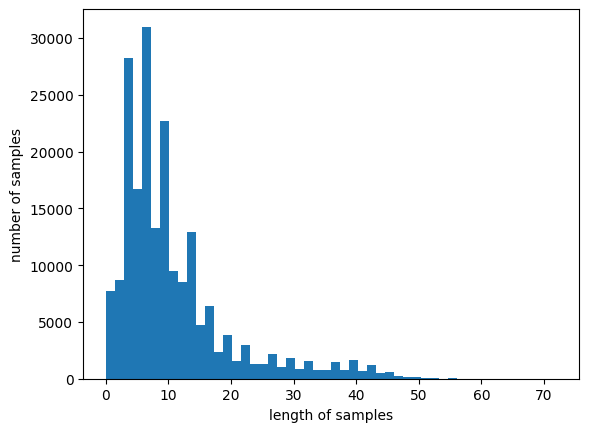

In [86]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))

plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples') # 리뷰 길이
plt.ylabel('number of samples') # 해당 리뷰 길이에 속하는 데이터의 개수
plt.show()

## 4.Word2Vec 학습

In [87]:


# 모델 학습


In [ ]:
# 완성된 임베딩 매트릭스의 크기 확인
